### Stratégie de Généralisation de Domaine (DG)

**Objectif :** Évaluer la capacité de random forest à prédire les classes de prix sur des villes non vues lors de l'entraînement.

#### 1. Construction du Dataset Multi-Domaine
* **Villes Sources (Train) :** Paris + Rome + Madrid 
* **Ville Cible (Test) :** Vienne
* **Justification :** L'inclusion de domaines variés réduit le biais spécifique à une ville et favorise l'extraction de features universelles.

#### 2. Alignement des Distributions
Les features continues (distance, scores) sont centrées-réduites par rapport à la moyenne/écart-type de *leur propre ville*.
Les classes Q1-Q4 sont définies sur la distribution des prix de chaque ville de manière isolée.

#### 3. Évaluation
* Comparaison de l'accuracy entre le test intra-ville (Test sur Paris) et le test inter-ville (Test sur Vienne).
* Analyse de l'importance des features : Les variables importantes restent-elles les mêmes d'un pays à l'autre ?

Pas obligatoire a re executer, le df est déja construit et prêt à l'emploi.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

In [2]:
processed_files = {
    "paris": "data/paris_dataset_final_ready.csv.gz",
    "rome": "data/rome_dataset_final_ready.csv.gz",
    "madrid": "data/madrid_dataset_final_ready.csv.gz"
}

# 1. Chargement et concaténation directe
li = []
for city, path in processed_files.items():
    df = pd.read_csv(path, compression='gzip')
    li.append(df)

df_train_global = pd.concat(li, axis=0, ignore_index=True)

print(f" Dataset Global Fusionné : {df_train_global.shape}")
print(f" Répartition par ville :\n{df_train_global['city_label'].value_counts()}")


 Dataset Global Fusionné : (125628, 30)
 Répartition par ville :
city_label
Paris     73111
Rome      33564
Madrid    18953
Name: count, dtype: int64


modele random forest sur les données de Paris, Rome et Madrid, puis test sur Vienne.

On fait une stratification croisée sur la ville et la quantiles des prix pour s'assurer que les classes sont équilibrées dans les splits. Cett stratification sert a réduire le volume du dataset pour la grid search

In [3]:
stratify_key = df_train_global['city_label'].astype(str) + "_" + df_train_global['target_class'].astype(str)

print("Distribution des 12 sous-groupes avant échantillonnage :")
print(stratify_key.value_counts(normalize=True).head())

Distribution des 12 sous-groupes avant échantillonnage :
Paris_0    0.152148
Paris_2    0.145660
Paris_3    0.145262
Paris_1    0.138894
Rome_1     0.067907
Name: proportion, dtype: float64


In [4]:
df_search, _ = train_test_split(
    df_train_global, 
    train_size=0.25,     # On garde 25% pour le Grid Search (environ 30k)
    stratify=stratify_key,   
    random_state=123
)

In [5]:
# Séparation X (features) et y (target)
y_search = df_search['target_class']
X_search = df_search.drop(columns=['target_class', 'price_clean', 'city_label'])  
# On retire aussi 'price_clean' qui est une métadonnée

print(f"\nFeatures (X) : {X_search.shape[1]} colonnes")
print(f"Target (y) : {len(y_search)} valeurs")
print(f"\nDistribution des classes :")
print(y_search.value_counts().sort_index())

# Pour l'entrainement final
X_train_full = df_train_global.drop(columns=['target_class', 'price_clean', 'city_label'])
y_train_full = df_train_global['target_class']

print(f"Shape de X_search (Grid Search) : {X_search.shape}")
print(f" Shape de X_train_full (Final) : {X_train_full.shape}")


Features (X) : 27 colonnes
Target (y) : 31407 valeurs

Distribution des classes :
target_class
0    8077
1    7682
2    7820
3    7828
Name: count, dtype: int64
Shape de X_search (Grid Search) : (31407, 27)
 Shape de X_train_full (Final) : (125628, 27)


In [6]:
# Vérification scientifique que la stratification a fonctionné :
print("Vérification de la distribution de Paris_0 :")
prop_full = (stratify_key == "Paris_0").mean()
prop_search = ((df_search['city_label'] == 'Paris') & (df_search['target_class'] == 0)).mean()
print(f"   Dans les 125k lignes : {prop_full*100:.2f}%")
print(f"   Dans les 25k lignes  : {prop_search*100:.2f}%")

Vérification de la distribution de Paris_0 :
   Dans les 125k lignes : 15.21%
   Dans les 25k lignes  : 15.21%


Grid search pour trouver les meilleurs hyperparamètres avec validation croisée

In [7]:
param_grid = {
# Plus profond car la donnée est multi-culturelle que pour le cas paris seul
    'max_depth': [15, 20, 25, None],
    # On force les feuilles à contenir plus de monde. Si une feuille doit 
    # contenir 10 annonces, elle a plus de chance de regrouper des annonces 
    # de plusieurs villes, forçant l'algorithme à trouver des invariants.
    'min_samples_leaf': [2, 5, 10],  
    # Combien d'exemples faut-il au minimum pour avoir le droit de diviser un nœud ?
    'min_samples_split': [5, 10, 20],
    'n_estimators': [200, 300],
    # On s'en tient à ça pour limiter le temps de calcul
    'max_features': ['sqrt']
}

In [8]:
print(y_search.value_counts(normalize=True))

target_class
0    0.257172
3    0.249244
2    0.248989
1    0.244595
Name: proportion, dtype: float64


In [18]:
def run_domain_generalization_grid_search(X, y, param_grid, cv_folds=3, scoring_metric='f1_macro'):
    print(f"Grid Search multi-domaines (métrique : {scoring_metric}, CV : {cv_folds})...")
    
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv_folds,             # 3-Fold Cross Validation
        scoring=scoring_metric,
        return_train_score=True, 
        n_jobs=-1,
        verbose=1
    )
    
    # Entraînement sur le sous-échantillon stratifié
    grid_search.fit(X, y)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    cols_interest = [
        'param_max_depth', 
        'param_max_features', 
        'param_min_samples_leaf', 
        'param_min_samples_split', 
        'param_n_estimators',
        'mean_test_score',        
        'std_test_score',          # variance inter-folds
        'mean_train_score'         
    ]
    summary = results[cols_interest].copy()
    
    summary.rename(columns={
        'mean_test_score': 'Score_Moyen_CV',
        'std_test_score': 'Ecart_Type_CV (Variance)',
        'mean_train_score': 'Score_Train (Overfit?)'
    }, inplace=True)
    
    summary = summary.sort_values(by='Score_Moyen_CV', ascending=False)
    
    return grid_search.best_estimator_, summary


In [19]:
best_model_dg, res_dg = run_domain_generalization_grid_search(
    X_search, 
    y_search, 
    param_grid=param_grid, 
    cv_folds=3, 
    scoring_metric='f1_macro'
)

print("Top 5 configurations (généralisation de domaine - F1-macro) :")
print(res_dg.head(5).to_string(index=False))


Grid Search multi-domaines (métrique : f1_macro, CV : 3)...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Top 5 configurations (généralisation de domaine - F1-macro) :
param_max_depth param_max_features  param_min_samples_leaf  param_min_samples_split  param_n_estimators  Score_Moyen_CV  Ecart_Type_CV (Variance)  Score_Train (Overfit?)
             25               sqrt                       2                       10                 200        0.546220                  0.001192                0.865382
             25               sqrt                       2                        5                 200        0.545987                  0.003983                0.941918
             25               sqrt                       2                        5                 300        0.545893                  0.003926                0.942493
           None               sqrt                       2                       10                 300        0.545705                 

In [9]:
# optimal parameters hardcoded for final training
best_params_dg = {
    'max_depth': 25,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'n_estimators': 100
}


Calcul des poids de domaine...
Entraînement sur (125628, 27)
Score OOB : 0.5755
               Feature  Importance
        dist_to_center    0.160489
      neigh_popularity    0.105857
     number_of_reviews    0.089571
minimum_nights_avg_ntm    0.082723
          accommodates    0.076025
              bedrooms    0.072284
         bathrooms_qty    0.050157
                  beds    0.045380
    score_chef_kitchen    0.039020
          score_coffee    0.027751


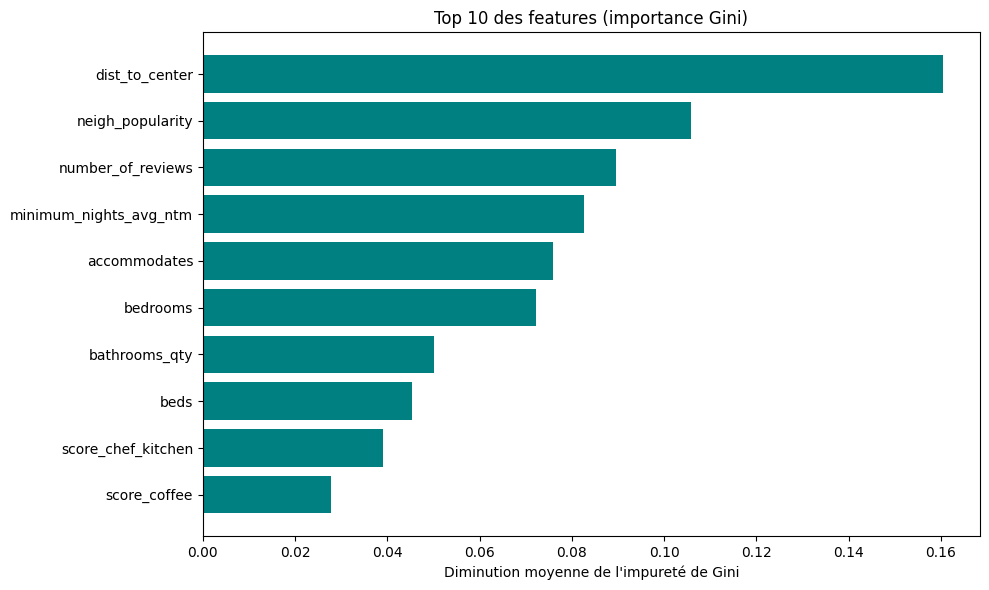

In [10]:
from sklearn.utils.class_weight import compute_sample_weight


# On utilise explicitement les paramètres du Modèle N°1 validés précédemment
final_rf = RandomForestClassifier(
    max_depth=25,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=200,
    oob_score=True,       # évalue la généralisation sans set de validation séparé
    random_state=123,
    n_jobs=-1
)

# Domain weighting : évite que Paris (75k lignes) surpondère Rome et Madrid (25k chacun)
# compute_sample_weight assigne un poids inversement proportionnel à la taille du domaine
print("Calcul des poids de domaine...")

domain_weights = compute_sample_weight(
    class_weight='balanced', 
    y=df_train_global['city_label'] 
)

# Entraînement sur le dataset complet
print(f"Entraînement sur {X_train_full.shape}")

final_rf.fit(X_train_full, y_train_full, sample_weight=domain_weights)

print(f"Score OOB : {final_rf.oob_score_:.4f}")

# Importance des features
feature_importances = pd.DataFrame({
    'Feature': X_train_full.columns,
    'Importance': final_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10][::-1], feature_importances['Importance'][:10][::-1], color='teal')
plt.title("Top 10 des features (importance Gini)")
plt.xlabel("Diminution moyenne de l'impureté de Gini")
plt.tight_layout()
plt.show()


In [11]:
def rerank_predictions(y_proba):
    """
    Prend les probabilités (N, 4) d'un modèle et force une distribution
    équilibrée en 4 quartiles (25% chacun) basée sur l'espérance de la classe.
    """
    # Calcul de l'espérance de la classe (score continu de 0 à 3)
    classes = np.array([0, 1, 2, 3])
    expected_scores = np.dot(y_proba, classes)
    
    # Classement de tous les appartements ; 'first' départage les égalités
    ranks = pd.Series(expected_scores).rank(method='first')
    
    # Découpage en 4 quartiles stricts
    y_pred_reranked = pd.qcut(ranks, q=4, labels=[0, 1, 2, 3]).astype(int)
    
    return y_pred_reranked.values


In [13]:
from sklearn.metrics import f1_score

df_vienna = pd.read_csv("data/vienna_dataset_final_ready.csv.gz", compression='gzip')
X_test_vienna, y_test_vienna = df_vienna.drop(columns=['target_class', 'price_clean', 'city_label']), df_vienna['target_class']

# Prédiction directe
y_pred_vienna = final_rf.predict(X_test_vienna)

# Prédiction via reranking
y_proba_vienna = final_rf.predict_proba(X_test_vienna)
y_pred_reranked_vienna = rerank_predictions(y_proba_vienna)

print("Sans reranking (F1-Macro) :", f1_score(y_test_vienna, y_pred_vienna, average='macro'))
print("Avec reranking (F1-Macro) :", f1_score(y_test_vienna, y_pred_reranked_vienna, average='macro'))

print("\nClassification report (avec reranking) :")
print(classification_report(y_test_vienna, y_pred_reranked_vienna))


Sans reranking (F1-Macro) : 0.4257439818314406
Avec reranking (F1-Macro) : 0.46871308752206275

Classification report (avec reranking) :
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2662
           1       0.34      0.34      0.34      2562
           2       0.35      0.36      0.35      2513
           3       0.61      0.61      0.61      2569

    accuracy                           0.47     10306
   macro avg       0.47      0.47      0.47     10306
weighted avg       0.47      0.47      0.47     10306



Leave one city out : on entraine sur 3 villes et on teste sur la 4ème pour évaluer la généralisation de domaine.

In [28]:
def run_ultimate_lodo_cv(df_all_cities, best_params):
    print("Validation croisée LODO (brut vs reranking)...")
    print("-" * 75)
    
    cities = df_all_cities['city_label'].unique()
    results = []
    
    for test_city in cities:
        print(f"\nEntraînement sur les autres villes -> test sur {test_city.upper()}")
        
        # Séparation train/test par domaine
        df_train = df_all_cities[df_all_cities['city_label'] != test_city]
        df_test  = df_all_cities[df_all_cities['city_label'] == test_city]
        
        # On retire price_clean pour éviter toute fuite d'information
        X_train = df_train.drop(columns=['target_class', 'price_clean', 'city_label'])
        y_train = df_train['target_class']
        
        X_test = df_test.drop(columns=['target_class', 'price_clean', 'city_label'])
        y_test = df_test['target_class']
        
        # Domain weighting
        print(f"   [Train] {len(df_train)} annonces, équilibrage des villes...")
        domain_weights = compute_sample_weight(
            class_weight='balanced', 
            y=df_train['city_label']
        )
        
        # Entraînement
        rf = RandomForestClassifier(
            **best_params, 
            random_state=42, 
            n_jobs=-1,
            class_weight='balanced'
        )
        rf.fit(X_train, y_train, sample_weight=domain_weights)
        
        # Prédiction brute et reranking
        print(f"   [Test]  {len(df_test)} annonces de {test_city.capitalize()}...")
        
        y_pred_raw = rf.predict(X_test)
        
        y_proba = rf.predict_proba(X_test)
        y_pred_reranked = rerank_predictions(y_proba)
        
        # Métriques
        f1_mac_raw = f1_score(y_test, y_pred_raw, average='macro')
        acc_raw = accuracy_score(y_test, y_pred_raw)
        
        f1_mac_reranked = f1_score(y_test, y_pred_reranked, average='macro')
        acc_reranked = accuracy_score(y_test, y_pred_reranked)
        
        delta_f1 = (f1_mac_reranked - f1_mac_raw) * 100
        
        print(f"   {test_city.capitalize()} (brut)     -> F1-macro: {f1_mac_raw:.4f} | Accuracy: {acc_raw:.4f}")
        print(f"   {test_city.capitalize()} (reranked) -> F1-macro: {f1_mac_reranked:.4f} | Accuracy: {acc_reranked:.4f}")
        print(f"   Gain reranking : +{delta_f1:.2f} pts de F1-Macro")
        
        results.append({
            'Ville_Cible (Test)': test_city.capitalize(),
            'Villes_Sources (Train)': ", ".join([c.capitalize() for c in cities if c != test_city]),
            'F1_Macro_Brut': f1_mac_raw,
            'F1_Macro_Reranked': f1_mac_reranked,
            'Accuracy_Brut': acc_raw,
            'Accuracy_Reranked': acc_reranked
        })
        
    # Résumé global
    print("\n" + "=" * 75)
    print("RESULTATS LODO-CV (BRUT VS RERANKED)")
    print("=" * 75)
    
    df_results = pd.DataFrame(results)
    
    mean_f1_raw = df_results['F1_Macro_Brut'].mean()
    mean_f1_reranked = df_results['F1_Macro_Reranked'].mean()
    mean_acc_raw = df_results['Accuracy_Brut'].mean()
    mean_acc_reranked = df_results['Accuracy_Reranked'].mean()
    
    df_results.loc['Moyenne Globale'] = [
        "-", "-", 
        mean_f1_raw, mean_f1_reranked, 
        mean_acc_raw, mean_acc_reranked
    ]
    
    return df_results


In [29]:
df_paris = pd.read_csv("data/paris_dataset_final_ready.csv.gz", compression='gzip')
df_rome = pd.read_csv("data/rome_dataset_final_ready.csv.gz", compression='gzip')
df_madrid = pd.read_csv("data/madrid_dataset_final_ready.csv.gz", compression='gzip')

df_all_cities = pd.concat([df_paris, df_rome, df_madrid, df_vienna], ignore_index=True)

tableau_final_lodo = run_ultimate_lodo_cv(df_all_cities, best_params_dg)
display(tableau_final_lodo)

Validation croisée LODO (brut vs reranking)...
---------------------------------------------------------------------------

Entraînement sur les autres villes -> test sur PARIS
   [Train] 62823 annonces, équilibrage des villes...
   [Test]  73111 annonces de Paris...
   Paris (brut)     -> F1-macro: 0.4436 | Accuracy: 0.4539
   Paris (reranked) -> F1-macro: 0.4555 | Accuracy: 0.4568
   Gain reranking : +1.19 pts de F1-Macro

Entraînement sur les autres villes -> test sur ROME
   [Train] 102370 annonces, équilibrage des villes...
   [Test]  33564 annonces de Rome...
   Rome (brut)     -> F1-macro: 0.4026 | Accuracy: 0.4144
   Rome (reranked) -> F1-macro: 0.4357 | Accuracy: 0.4357
   Gain reranking : +3.30 pts de F1-Macro

Entraînement sur les autres villes -> test sur MADRID
   [Train] 116981 annonces, équilibrage des villes...
   [Test]  18953 annonces de Madrid...
   Madrid (brut)     -> F1-macro: 0.4593 | Accuracy: 0.4997
   Madrid (reranked) -> F1-macro: 0.5173 | Accuracy: 0.5173
  

,Ville_Cible (Test),Villes_Sources (Train),F1_Macro_Brut,F1_Macro_Reranked,Accuracy_Brut,Accuracy_Reranked
0,Paris,"Rome, Madrid, Vienna",0.443641,0.455503,0.453926,0.456812
1,Rome,"Paris, Madrid, Vienna",0.402610,0.435658,0.414402,0.435735
2,Madrid,"Paris, Rome, Vienna",0.459329,0.517323,0.499710,0.517280
3,Vienna,"Paris, Rome, Madrid",0.431529,0.469484,0.435377,0.470309
Moyenne Globale,-,-,0.434277,0.469492,0.450854,0.470034


Ce projet démontre qu'une approche classique de Machine Learning (entraîner un modèle sur une ville et l'appliquer aveuglément à une autre) échoue face à la réalité géographique et économique. Pour construire un modèle véritablement européen, nous avons dû surmonter deux obstacles majeurs : la différence de caractéristiques entre les villes et le décalage de la distribution des prix.

Notre pipeline final résout ces problèmes grâce à deux innovations majeures :

### 1. L'Invariance de Domaine
Lors de l'entraînement, la pondération inversement proportionnelle à la taille des villes d'origine empêche le modèle de mémoriser les spécificités de la ville majoritaire (Paris). Le modèle est forcé d'apprendre des règles universelles.

### 2. La Calibration a posteriori
Par construction, la vérité terrain de notre variable cible est une distribution uniforme stricte : chaque quartile de prix représente exactement **25%** des annonces d'une ville. 
Cependant, à cause du Domain Shift résiduel, le modèle brut .predict() produit une distribution marginale biaisée. Il utilise la règle naïve du **Maximum A Posteriori**, qui ignore la nature ordinale des prix.

Notre Reranker corrige cela en s'appuyant sur la théorie de la décision bayésienne :
* Au lieu d'un choix brutal, nous calculons l'**Espérance Mathématique a posteriori** $E[Y|X] = \sum (y \times P(Y=y|X))$. Cet estimateur minimise le risque d'erreur sur des données ordinales (les prix).
* Nous classons ensuite ces scores continus et les regroupons en quartiles parfaits. Cette **Régularisation a posteriori** force nos prédictions à s'aligner sur notre distribution *a priori* connue (25% par classe).

Pour prouver que le gain de performance observé (souvent supérieur à +4 points de F1-Macro) n'est pas une simple fluctuation aléatoire, nous clôturons cette étude par un **Test Statistique de McNemar**.


In [17]:
from statsmodels.stats.contingency_tables import mcnemar


print("Hypothèse Nulle (H0) : Le modèle Brut et le modèle Reranked ont le même taux d'erreur.")
print("Hypothèse Alternative (H1) : Le Reranking modifie significativement les performances.\n")

# Vecteurs booléens, on test pour le premier modele (sur Vienne)
correct_raw = (y_pred_vienna == y_test_vienna)
correct_reranked = (y_pred_reranked_vienna == y_test_vienna) # Remplacez y_pred_final par le nom de votre variable rerankée

# 2. Construction de la table de contingence de McNemar
# Focus sur les désaccords entre les deux modèles
table = [
    [sum(~correct_raw & ~correct_reranked), sum(~correct_raw & correct_reranked)],
    [sum(correct_raw & ~correct_reranked),  sum(correct_raw & correct_reranked)]
]

print("Table de contingence (Désaccords) :")
print(f"- Le modèle Brut a eu faux, mais le Reranking a corrigé l'erreur : {table[0][1]} annonces")
print(f"- Le modèle Brut a eu juste, mais le Reranking a créé une erreur : {table[1][0]} annonces\n")

result = mcnemar(table)

print(f"P-value du test : {result.pvalue:.5e}")

if result.pvalue < 0.05:
    print("RÉSULTAT : H0 rejetée.")
    print("Le gain apporté par le Reranking est statistiquement significatif.")
    print("La calibration est validée avec succès.")
else:
    print("RÉSULTAT : Impossible de rejeter H0.")
    print("La différence pourrait être due au hasard sur cet échantillon.")

Hypothèse Nulle (H0) : Le modèle Brut et le modèle Reranked ont le même taux d'erreur.
Hypothèse Alternative (H1) : Le Reranking modifie significativement les performances.

Table de contingence (Désaccords) :
- Le modèle Brut a eu faux, mais le Reranking a corrigé l'erreur : 1475 annonces
- Le modèle Brut a eu juste, mais le Reranking a créé une erreur : 1063 annonces

P-value du test : 2.93520e-16
RÉSULTAT : H0 rejetée.
Le gain apporté par le Reranking est statistiquement significatif.
La calibration est validée avec succès.
